In [2]:
import zipfile
import os
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
import pandas as pd
import cv2
import torch.optim as optim
from helpers import Helpers
from torch.utils.data import Dataset
from PIL import Image
from sklearn.model_selection import KFold
from torch.utils.data import DataLoader, Subset
import random
import numpy as np

seed = 0
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
zip_path = '/content/WARWICK_val.zip'
extract_path = '/content/'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

extract_path = '/content/WARWICK_val'

train_path = os.path.join(extract_path, 'Train')
test_path = os.path.join(extract_path, 'Test')


In [89]:
class WarwickDataset(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.startswith('image_')])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.startswith('label_')])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])

        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
            image = image[0:2,:,:]
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

class WarwickDatasetGray(Dataset):
    def __init__(self, image_dir, label_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_files = sorted([f for f in os.listdir(image_dir) if f.startswith('image_')])
        self.label_files = sorted([f for f in os.listdir(label_dir) if f.startswith('label_')])
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        label_path = os.path.join(self.label_dir, self.label_files[idx])
        image = Image.open(img_path).convert("RGB")
        label = Image.open(label_path).convert("L")

        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [139]:
import torchvision.transforms as T

image_transform = transforms.Compose([
    transforms.ToTensor(),
    ])

label_transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = WarwickDataset(
    image_dir=os.path.join(extract_path, 'Train'),
    label_dir=os.path.join(extract_path, 'Train'),
    transform=image_transform,
    target_transform=label_transform
)

test_dataset = WarwickDataset(
    image_dir=os.path.join(extract_path, 'Test'),
    label_dir=os.path.join(extract_path, 'Test'),
    transform=image_transform,
    target_transform=label_transform
)

val_dataset = WarwickDataset(
    image_dir=os.path.join(extract_path, 'Validation'),
    label_dir=os.path.join(extract_path, 'Validation'),
    transform=image_transform,
    target_transform=label_transform
)

augmentation_trans = T.Compose([
    T.Grayscale(num_output_channels=1),
    T.ToTensor(),
    T.Normalize(mean=[0.5], std=[0.5])
])

train_dataset_aug = WarwickDatasetGray(
    image_dir=os.path.join(extract_path, 'Train'),
    label_dir=os.path.join(extract_path, 'Train'),
    transform=augmentation_trans,
    target_transform=label_transform
)

val_dataset_aug = WarwickDatasetGray(
    image_dir=os.path.join(extract_path, 'Validation'),
    label_dir=os.path.join(extract_path, 'Validation'),
    transform=augmentation_trans,
    target_transform=label_transform
)

test_dataset_aug = WarwickDatasetGray(
    image_dir=os.path.join(extract_path, 'Test'),
    label_dir=os.path.join(extract_path, 'Test'),
    transform=augmentation_trans,
    target_transform=label_transform
)


torch.Size([6, 2, 128, 128])
torch.Size([6, 1, 128, 128])


TypeError: Invalid shape (128, 128, 2) for image data

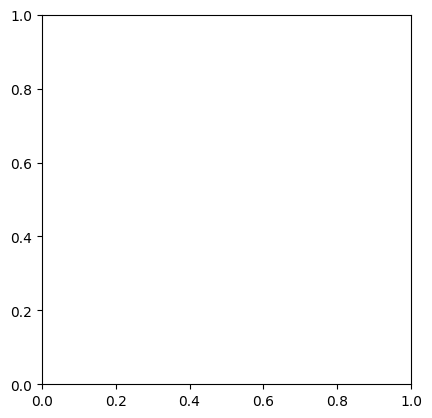

In [144]:
batch_size = 6
num_workers = 1
train_loader = DataLoader(train_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset_aug, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=seed_worker)

for images, labels in test_loader:
    print(images.shape)
    print(labels.shape)
    break

plt.imshow(images[1].permute(1,2,0), cmap='gray')
plt.show()

In [113]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UnetInspiredGrayScale(nn.Module):
    def __init__(self):
        super(UnetInspiredGrayScale, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16

        # decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 to 32x32
            nn.ReLU()
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 to 64x64
            nn.ReLU()
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64x64 to 128x128
            nn.ReLU()
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding=1),
            nn.ReLU()
        )
        self.out = nn.Conv2d(16, 1, kernel_size=1)  # classification, 128x128x1
        self.initialize_weights()

    def forward(self, x):
        # encoding
        x128 = self.enc1(x)
        x = self.pool1(x128)
        x64 = self.enc2(x)
        x = self.pool2(x64)
        x32 = self.enc3(x)
        x = self.pool3(x32)

        # decoding
        x = self.up1(x)              # 32x32
        x = torch.cat([x, x32], dim=1)
        x = self.dec1(x)
        x = self.up2(x)              # 64x64
        x = torch.cat([x, x64], dim=1)
        x = self.dec2(x)
        x = self.up3(x)              # 128x128
        x = torch.cat([x, x128], dim=1)
        x = self.dec3(x)
        out = self.out(x)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.manual_seed(0)  # viktigaste!!!!
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationOne(nn.Module):
    def __init__(self, dropout_proba=0.15):
        super(VariationOne, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(2, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64
        self.enc2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32
        self.enc3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16

        # decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),  # 16x16 to 32x32
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),  # 32x32 to 64x64
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(32, 16, kernel_size=4, stride=2, padding=1),  # 64x64 to 128x128
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(32 + 16, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.out = nn.Conv2d(16, 1, kernel_size=1)  # classification, 128x128x1
        self.initialize_weights()

    def forward(self, x):
        # encoding
        x128 = self.enc1(x)
        x = self.pool1(x128)
        x64 = self.enc2(x)
        x = self.pool2(x64)
        x32 = self.enc3(x)
        x = self.pool3(x32)

        # decoding
        x = self.up1(x)              # 32x32
        x = torch.cat([x, x32], dim=1)
        x = self.dec1(x)
        x = self.up2(x)              # 64x64
        x = torch.cat([x, x64], dim=1)
        x = self.dec2(x)
        x = self.up3(x)              # 128x128
        x = torch.cat([x, x128], dim=1)
        x = self.dec3(x)
        out = self.out(x)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.manual_seed(0)  # viktigaste!!!!
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

In [115]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VariationTwo(nn.Module):
    def __init__(self, dropout_proba=0.15):
        super(VariationTwo, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16

        # decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.out = nn.Conv2d(32, 1, kernel_size=1)  # final output
        self.initialize_weights()

    def forward(self, x):
        # encoding
        x128 = self.enc1(x)
        x = self.pool1(x128)
        x64 = self.enc2(x)
        x = self.pool2(x64)
        x32 = self.enc3(x)
        x = self.pool3(x32)

        # decoding
        x = self.up1(x)
        x = torch.cat([x, x32], dim=1)
        x = self.dec1(x)
        x = self.up2(x)
        x = torch.cat([x, x64], dim=1)
        x = self.dec2(x)
        x = self.up3(x)
        x = torch.cat([x, x128], dim=1)
        x = self.dec3(x)
        out = self.out(x)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.manual_seed(0)
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [131]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class VersionFour(nn.Module):
    def __init__(self, dropout_proba=0.08):
        super(VersionFour, self).__init__()
        # encoder
        self.enc1 = nn.Sequential(
            nn.Conv2d(2, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool1 = nn.MaxPool2d(2, 2)  # 64x64
        self.enc2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.pool2 = nn.MaxPool2d(2, 2)  # 32x32
        self.enc3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
        )
        self.pool3 = nn.MaxPool2d(2, 2)  # 16x16

        # decoder
        self.up1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec1 = nn.Sequential(
            nn.Conv2d(256 + 128, 128, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.up2 = nn.Sequential(
            nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec2 = nn.Sequential(
            nn.Conv2d(128 + 64, 64, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.up3 = nn.Sequential(
            nn.ConvTranspose2d(64, 32, kernel_size=4, stride=2, padding=1),
            nn.ReLU(),
            nn.Dropout2d(dropout_proba)
        )
        self.dec3 = nn.Sequential(
            nn.Conv2d(64 + 32, 32, kernel_size=3, padding=1),
            nn.ReLU(),
        )
        self.out = nn.Conv2d(32, 1, kernel_size=1)  # final output
        self.initialize_weights()

    def forward(self, x):
        # encoding
        x128 = self.enc1(x)
        x = self.pool1(x128)
        x64 = self.enc2(x)
        x = self.pool2(x64)
        x32 = self.enc3(x)
        x = self.pool3(x32)

        # decoding
        x = self.up1(x)
        x = torch.cat([x, x32], dim=1)
        x = self.dec1(x)
        x = self.up2(x)
        x = torch.cat([x, x64], dim=1)
        x = self.dec2(x)
        x = self.up3(x)
        x = torch.cat([x, x128], dim=1)
        x = self.dec3(x)
        out = self.out(x)
        return out

    def initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                torch.manual_seed(0)
                nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)


In [116]:
!pip install optuna

In [133]:
import torch
import torch.optim as optim
import torch.nn as nn
from torch.utils.data import DataLoader
import optuna

def objective(trial):
    # params to iterate between
    lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
    batch_size = trial.suggest_int('batch_size', 8, 16, step=8)
    weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)

    model = VersionFour()
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=seed_worker)
    best_val_dice = 0.0

    for epoch in range(15):
        model.train()

        train_loss = 0.0
        train_tp, train_fp, train_fn = 0.0, 0.0, 0.0  # tp, fp, fn

        # Training loop
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)

            loss = criterion(outputs, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
            train_tp += ((preds == 1) & (labels == 1)).sum().item()
            train_fp += ((preds == 1) & (labels == 0)).sum().item()
            train_fn += ((preds == 0) & (labels == 1)).sum().item()

        train_dice = (2. * train_tp) / (2. * train_tp + train_fp + train_fn + 1e-6)
        avg_train_loss = train_loss / len(train_loader)

        # evaluation
        model.eval()
        val_tp, val_fp, val_fn = 0.0, 0.0, 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)

                preds = (torch.sigmoid(outputs) > 0.5).float() # binarize
                val_tp += ((preds == 1) & (labels == 1)).sum().item()
                val_fp += ((preds == 1) & (labels == 0)).sum().item()
                val_fn += ((preds == 0) & (labels == 1)).sum().item()

        val_dice = (2. * val_tp) / (2. * val_tp + val_fp + val_fn + 1e-6) #1e-6 no division by zero
        best_val_dice = max(best_val_dice, val_dice) # storing best dice score

        trial.report(val_dice, epoch) # optuna quits the trial if not worth continuing
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return best_val_dice

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=0))
study.optimize(objective, n_trials=50)

print(f"Best hyperparameters: {study.best_params}")
print(f"Best validation Dice: {study.best_value}")


[I 2025-04-23 23:07:06,218] A new study created in memory with name: no-name-8d3288f4-67bc-4aa6-86c4-7be701a8943b
<ipython-input-133-94df23963a16>:9: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-6, 1e-3)
<ipython-input-133-94df23963a16>:11: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  weight_decay = trial.suggest_loguniform('weight_decay', 1e-8, 1e-4)
[I 2025-04-23 23:07:15,559] Trial 0 finished with value: 0.7091437496572778 and parameters: {'lr': 4.430375245218267e-05, 'batch_size': 16, 'weight_decay': 2.576638574613591e-06}. Best is trial 0 with value: 0.7091437496572778.
[I 2025-04-23 23:07:25,563] Trial 1 finished with value

Best hyperparameters: {'lr': 0.0008385584990618351, 'batch_size': 8, 'weight_decay': 2.1594375123170686e-07}
Best validation Dice: 0.812424788850376


Epoch 1/40 - Train Loss: 0.6792, Train Dice: 0.5956
Epoch 1/40 - Validation Loss: 0.6458, Validation Dice: 0.6785
Epoch 2/40 - Train Loss: 0.6077, Train Dice: 0.6577
Epoch 2/40 - Validation Loss: 0.5702, Validation Dice: 0.6977
Epoch 3/40 - Train Loss: 0.5846, Train Dice: 0.6844
Epoch 3/40 - Validation Loss: 0.6152, Validation Dice: 0.7102
Epoch 4/40 - Train Loss: 0.5876, Train Dice: 0.6509
Epoch 4/40 - Validation Loss: 0.5386, Validation Dice: 0.7305
Epoch 5/40 - Train Loss: 0.5660, Train Dice: 0.7096
Epoch 5/40 - Validation Loss: 0.5447, Validation Dice: 0.7006
Epoch 6/40 - Train Loss: 0.5115, Train Dice: 0.7278
Epoch 6/40 - Validation Loss: 0.5181, Validation Dice: 0.7644
Epoch 7/40 - Train Loss: 0.4928, Train Dice: 0.7664
Epoch 7/40 - Validation Loss: 0.5354, Validation Dice: 0.7644
Epoch 8/40 - Train Loss: 0.5273, Train Dice: 0.7476
Epoch 8/40 - Validation Loss: 0.5859, Validation Dice: 0.7441
Epoch 9/40 - Train Loss: 0.5231, Train Dice: 0.7428
Epoch 9/40 - Validation Loss: 0.5805

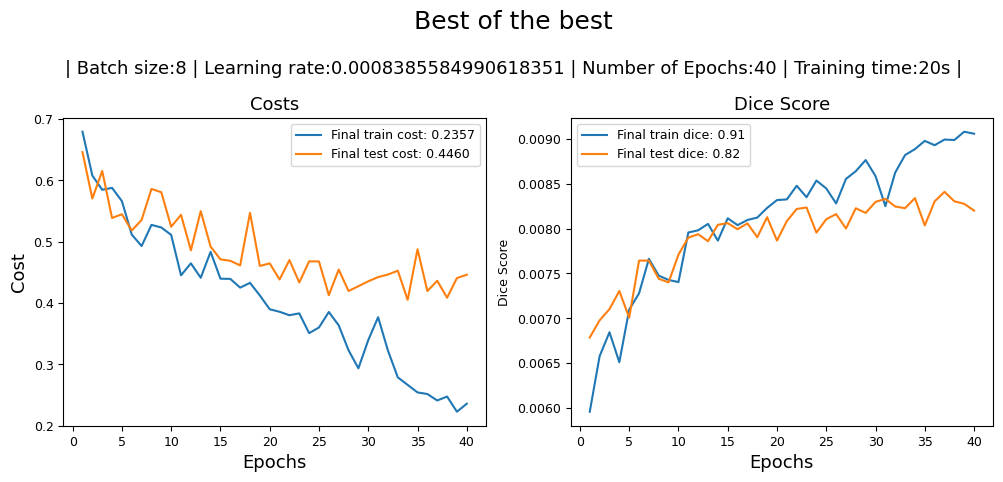

In [146]:
model = VersionFour()
lr = study.best_params['lr']
batch_size = study.best_params['batch_size']
EPOCHS = 40

optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=study.best_params['weight_decay'])
scheduler = None
criterion = nn.BCEWithLogitsLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, worker_init_fn=seed_worker)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker)

train_costs, test_costs, train_dices, test_dices, training_time = Helpers.training_loop(model, train_loader, val_loader, optimizer, scheduler, criterion, device, EPOCHS)

Helpers.training_curve_plot('Best of the best', train_costs, test_costs, train_dices, test_dices, batch_size, lr, EPOCHS, training_time)

In [148]:
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker)
model.eval()
test_loss = 0.0
test_tp, test_fp, test_fn = 0.0, 0.0, 0.0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        tp, fp, fn = Helpers.dice_components(outputs, labels, 0.5)
        test_tp += tp
        test_fp += fp
        test_fn += fn

test_dice = Helpers.dice_score(test_tp, test_fp, test_fn)
avg_test_loss = test_loss / len(test_loader)

print(f'Test Loss: {avg_test_loss:.4f}, Test Dice: {test_dice:.4f}')

Test Loss: 0.4657, Test Dice: 0.8308


In [127]:
print(study.best_params['batch_size'])
print(study.best_params['lr'])
print(study.best_params['weight_decay'])

8
0.0009559725127335095
1.492093109484628e-07


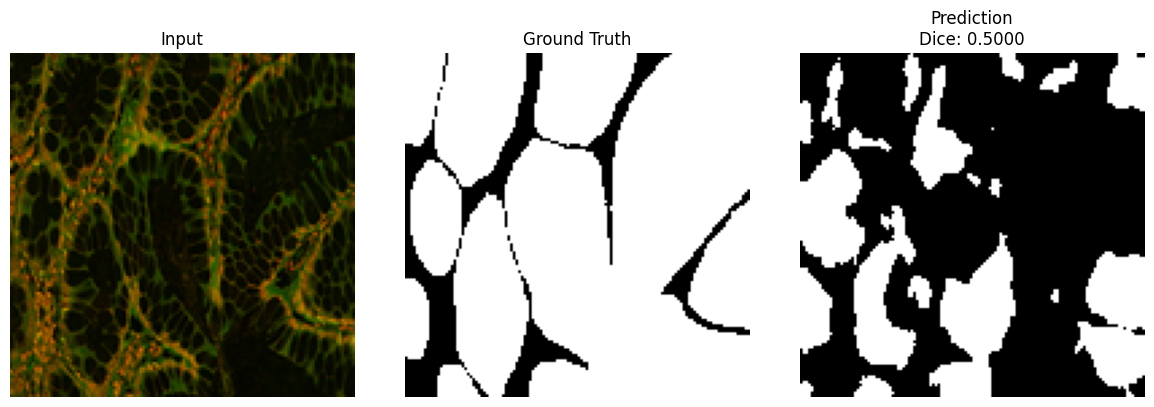

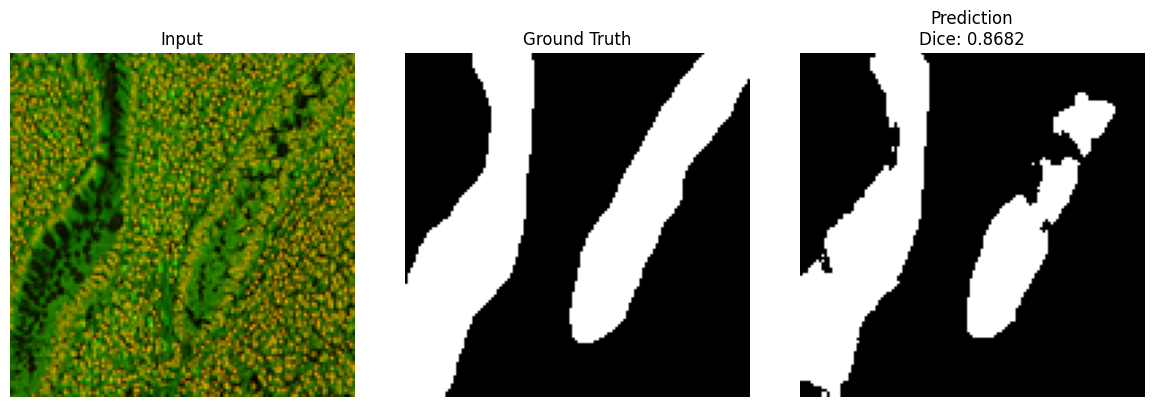

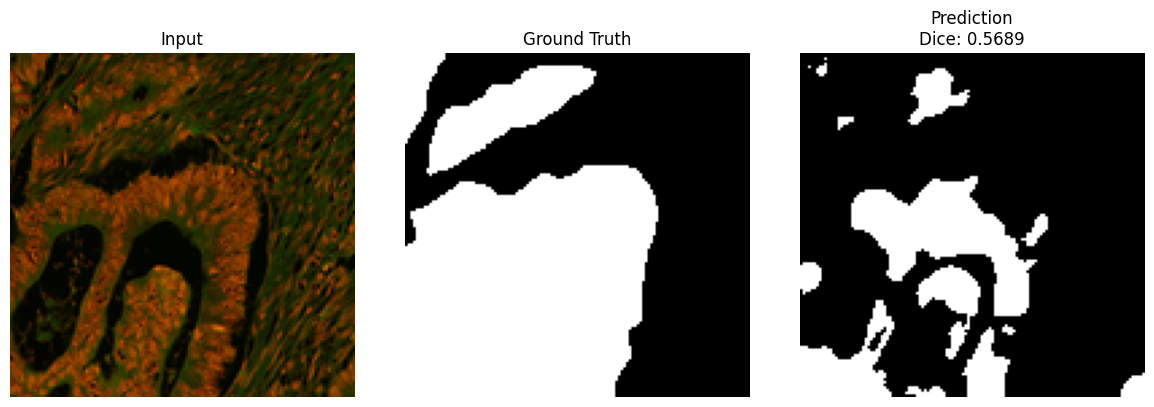

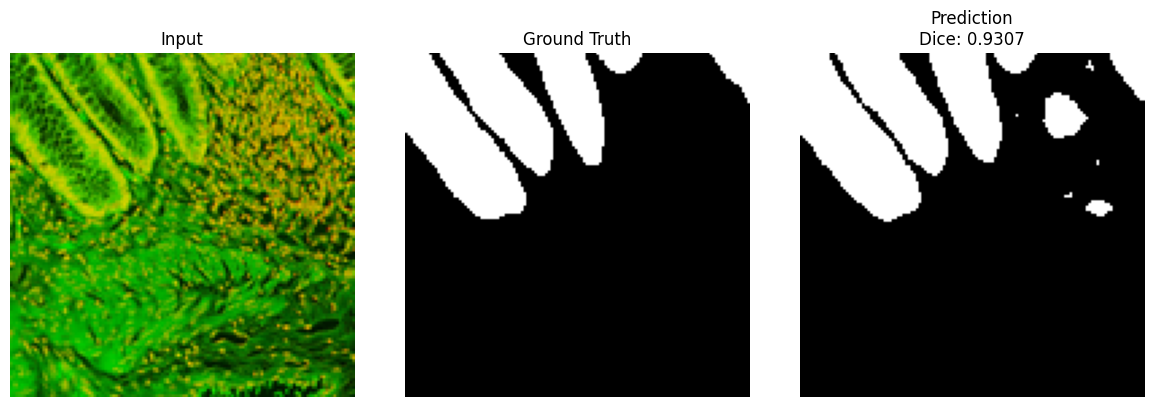

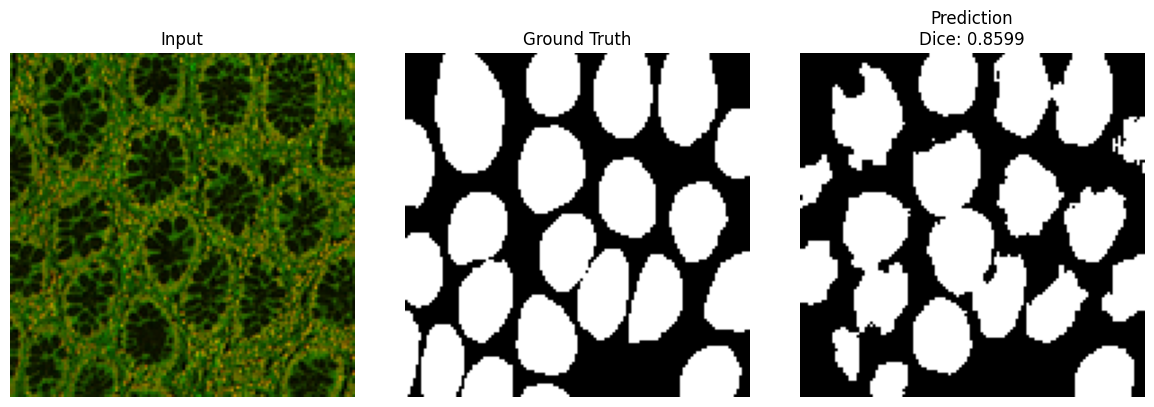

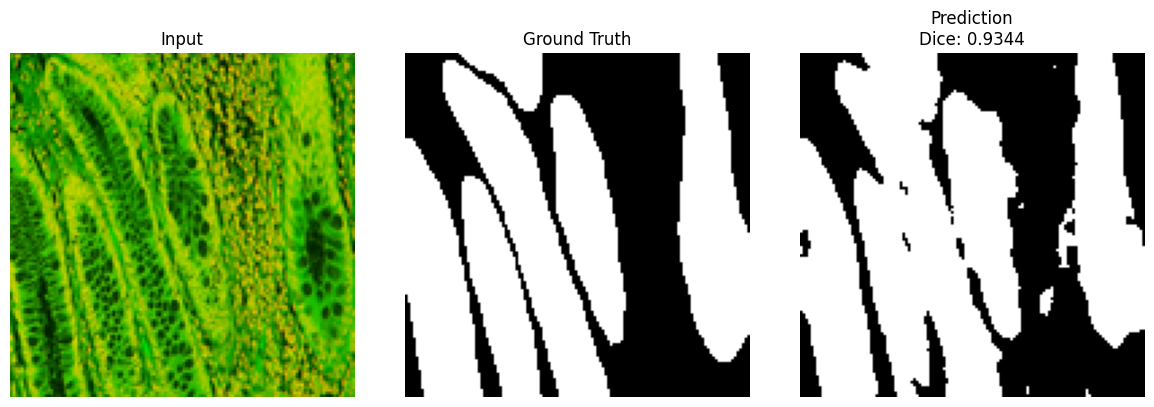

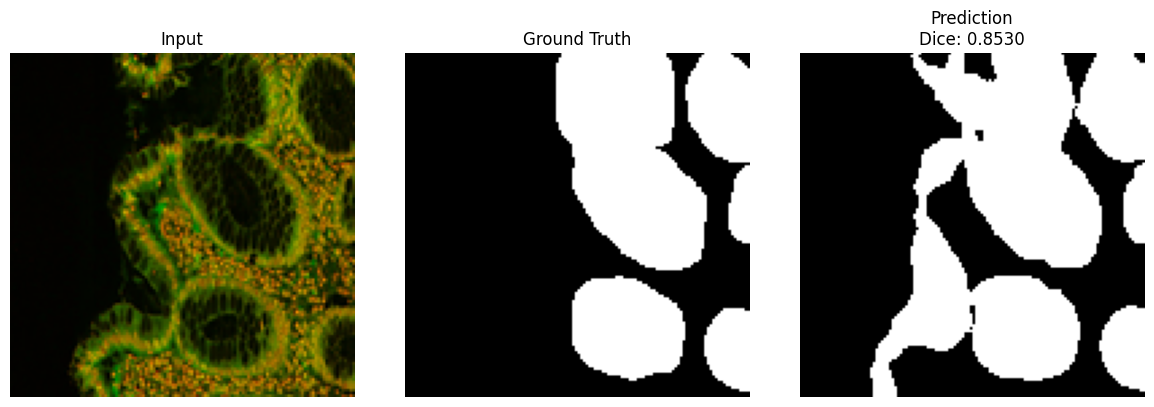

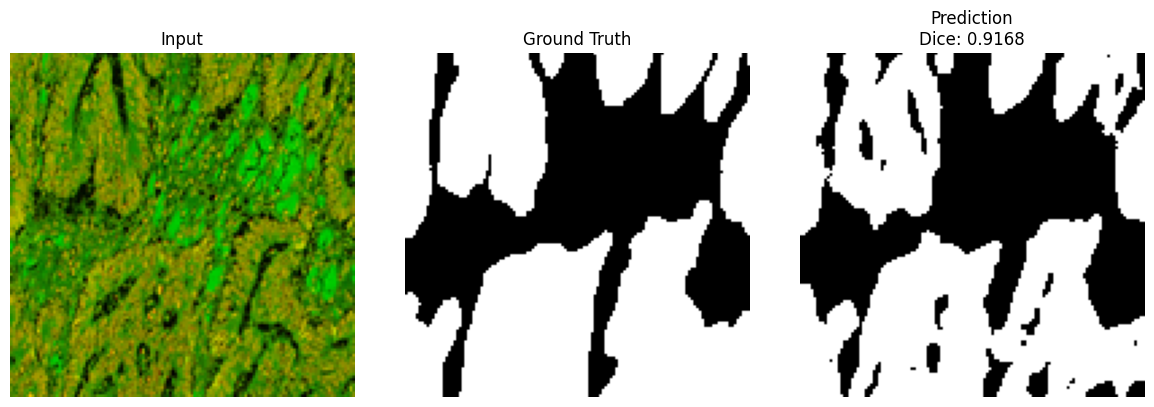

In [149]:
Helpers.visualize_predictions(model, test_loader, device, batch_size)
#Helpers.imshowpair(model, test_loader, device, batch_size)

In [129]:
def visualize_gray_predictions(model, loader, device, batch_size):
      model.eval()
      with torch.no_grad():
          images, labels = next(iter(loader))
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          preds = torch.sigmoid(outputs) > 0.5

          for i in range(min(batch_size, images.size(0))):
              img = images[i].cpu().permute(1, 2, 0).numpy()
              h, w, _ = img.shape
              lbl = labels[i].cpu().squeeze().numpy()
              pred = preds[i].cpu().squeeze().numpy()
              tp = ((pred == 1) & (lbl == 1)).sum()
              fp = ((pred == 1) & (lbl == 0)).sum()
              fn = ((pred == 0) & (lbl == 1)).sum()
              dice = (2 * tp) / (2 * tp + fp + fn + 1e-6)

              fig, axes = plt.subplots(1, 3, figsize=(12, 4))
              axes[0].imshow(img, cmap="gray")
              axes[0].set_title('Input')
              axes[0].axis('off')

              axes[1].imshow(lbl, cmap='gray')
              axes[1].set_title('Ground Truth')
              axes[1].axis('off')

              axes[2].imshow(pred, cmap='gray')
              axes[2].set_title(f'Prediction\nDice: {dice:.4f}')
              axes[2].axis('off')
              plt.tight_layout()
              plt.show()